<a href="https://colab.research.google.com/github/JiayuanFengSkyler/Python-SQL/blob/main/momentum_duckdb_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install duckdb

In [1]:
!pip install mysql.connector

     |████████████████████████████████| 11.9MB 5.7MB/s 
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp37-cp37m-linux_x86_64.whl size=247949 sha256=4942b28c5554384f9cc120e6047ec0197a8a54291b3f09d5f5e1496ed1847fbe
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql.connector


# Part 1 - Regression Model


In [3]:
#@title Regression for market premium
import mysql.connector
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import numpy as np

import statsmodels.api as sm # statistical models including regression
import scipy as sp # scientific calculation toolkit
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt # MATLAB-like plotting library
import gc # garbage collector
import time # time related utility functions

conn=mysql.connector.connect(host='147.8.122.231', user='fina_4359_fengjy18', password='9d93d', database='ff')
cursor=conn.cursor()
cursor.execute("SELECT mom,mkt_rf from ff.four_factor ff2 where mom is not NULL and mkt_rf is not null;")
mmt = []
mkt_prem = []
for (mom, mkt_rf) in cursor:
    mmt = mmt + [[float(mom)]]
    mkt_prem = mkt_prem + [[float(mkt_rf)]]

mkt_prem = sm.add_constant(mkt_prem)
model = sm.OLS(mmt,mkt_prem).fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     455.7
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          3.36e-100
Time:                        08:33:59   Log-Likelihood:                 85799.
No. Observations:               24753   AIC:                        -1.716e+05
Df Residuals:                   24751   BIC:                        -1.716e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   4.81e-05      6.131      0.000       0.000       0.000
x1            -0.0950      0.004    -21.347      0.000      -0.104      -0.086
==============================================================================
Omnibus:                    10926.855   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           508430.650
Skew:                          -1.390   Prob(JB):                         0.00
Kurtosis:                      25.028   Cond. No.                         92.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
#@title Regression for FF 4-factor model
import mysql.connector
import pandas as pd
import numpy as np

import statsmodels.api as sm # statistical models including regression
import scipy as sp # scientific calculation toolkit
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt # MATLAB-like plotting library
import gc # garbage collector
import time # time related utility functions

conn=mysql.connector.connect(host='147.8.122.231', user='fina_4359_fengjy18', password='9d93d', database='ff')
cursor=conn.cursor()
cursor.execute("SELECT mom,mkt_rf,smb,hml from ff.four_factor ff2 where mom is not NULL and mkt_rf is not null;")

mmt = []
mkt_prem = []
smb_ = []
hml_ = []

for (mom, mkt_rf, smb, hml) in cursor:
    mmt.append(float(mom))
    mkt_prem.append(float(mkt_rf))
    smb_.append(float(smb))
    hml_.append(float(hml))

df = pd.DataFrame({"mom": mmt, "mkt_rf": mkt_prem, "smb": smb_, "hml": hml_})
result = smf.ols(formula="mom ~ mkt_rf + smb + hml", data=df).fit()

print(result.params)
print(result.summary())

Intercept    0.000319
mkt_rf      -0.071409
smb          0.009420
hml         -0.231782
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    mom   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     440.4
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          9.03e-279
Time:                        08:34:26   Log-Likelihood:                 86217.
No. Observations:               24753   AIC:                        -1.724e+05
Df Residuals:                   24749   BIC:                        -1.724e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

# Part 2 - Mystery Meat Strategy

# SQL operations
Focus only on common stocks with exchange codes 1,2,3 (NYSE, Arca, Nasdaq), last month’s price greater than $1, by selecting from MyMysteryMeat.

In [ ]:

conn.execute("""
    SELECT permno, date, hexcd, prc_lag1, mcap_lag1, ret_lag1, ret,
    CASE WHEN (
            prc_lag2 is not null and mcap_lag13 is not null and 
            not_null>=8
        ) THEN exp(a.momentum_log)-1 else NULL end as momentum
    FROM (
      SELECT permno, date, prc_lag1,mcap_lag1, ret, 
      lag(abs(ret),1) OVER (PARTITION BY permno order by "date") as ret_lag1,
      lag(abs(prc),2) OVER (PARTITION BY permno  order by "date") as prc_lag2,
      sum(ln(1+ret)) over (PARTITION BY permno ORDER BY date
                  rows between 12 preceding and 2 preceding) as momentum_log,
      sum(case when ret is not null then 1 else 0 end) over (PARTITION BY permno ORDER BY date) as not_null,
      lag(abs(mcap),13) over (PARTITION BY permno ORDER BY date) as mcap_lag13,     
      hexcd
      FROM temp.hw3_mysterymeat_2021 hm 
      WHERE shrcd in (10,11) and hexcd in (1,2,3)) as a
      WHERE a.momentum_log is not null and a.prc_lag1>1;
  """
  )
r = conn.fetchall()

In [5]:
#@title Assign all stocks across all months

import mysql.connector
import pandas as pd
import numpy as np

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

portfolios.sort_values(['date', 'bin']).head(10)

,date,bin,portfolio_ew,portfolio_vw
0,1971-01-31,1,0.115097,0.039086
1,1971-01-31,2,0.149487,0.065426
2,1971-01-31,3,0.131671,0.068996
3,1971-01-31,4,0.149992,0.055189
4,1971-01-31,5,0.147044,0.045058
5,1971-01-31,6,0.127025,0.061144
6,1971-01-31,7,0.123109,0.022205
7,1971-01-31,8,0.114381,0.017906
8,1971-01-31,9,0.120177,0.073132
9,1971-01-31,10,0.129188,0.068194


# Portfolio Sorting

In [3]:
#@title Sharpe ratio of the decile 10 minus decile 1 strategy

import mysql.connector
import pandas as pd
import numpy as np
import statsmodels.api as sm # statistical models including regression
import scipy as sp # scientific calculation toolkit
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt # MATLAB-like plotting library
import gc # garbage collector
import time # time related utility functions

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)   
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    return pd.cut(x, quantiles, labels=False) + 1

required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()

portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

portfolios2 = pd.merge(
    portfolios.query('bin==10'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

portfolios2 = portfolios2.sort_values('date') # sort it first

portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']

portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1 # calculates the cumulative return

portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long'] - portfolios2['portfolio_ew_short']

portfolios2['cum_ew'] = (portfolios2['strategy_ew'] + 1).cumprod() - 1 # calculates the cumulative return

def sharpe(x):
    return x.mean() / x.std()
sharpe_vw = sharpe(portfolios2['strategy_vw'])
sharpe_ew = sharpe(portfolios2['strategy_ew'])

print('Annualized sharpe ratio momentum for value weighted: {}'.format(sharpe_vw * 12**0.5))
print('Annualized sharpe ratio momentum for equal weighted: {}'.format(sharpe_ew * 12**0.5))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Annualized sharpe ratio momentum for value weighted: 0.3823297733239199
Annualized sharpe ratio momentum for equal weighted: 0.8919719157747517


## Barplot: Comparing the monthly average return for each decile portfolio


In [8]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # MATLAB-like plotting library

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

dta = portfolios.groupby('bin').agg(vw=('portfolio_vw', 'mean')).sort_values('bin')

dta

,vw
bin,
1,0.009265
2,0.009787
3,0.010020
4,0.009420
5,0.010826
6,0.010535
7,0.010124
8,0.010798
9,0.011790


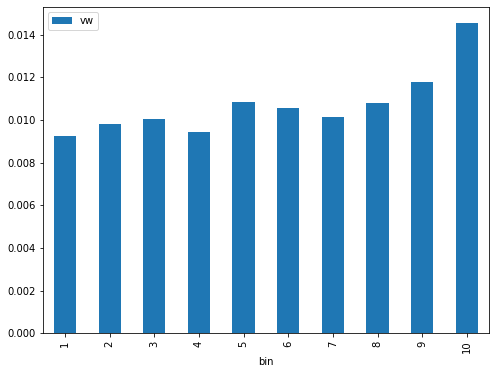

In [2]:
#@title Value Weighted Strategy

import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # MATLAB-like plotting library

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

dta = portfolios.groupby('bin').agg(vw=('portfolio_vw', 'mean')).sort_values('bin')

dta

# barplot to check monotonicity
plt.rcParams["figure.figsize"] = (8,6)
dta.plot(kind='bar')


In [9]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

dta = portfolios.groupby('bin').agg(ew=('portfolio_ew', 'mean')).sort_values('bin')

dta

,ew
bin,
1,0.005085
2,0.009002
3,0.010317
4,0.010949
5,0.011937
6,0.012438
7,0.012801
8,0.013373
9,0.013936


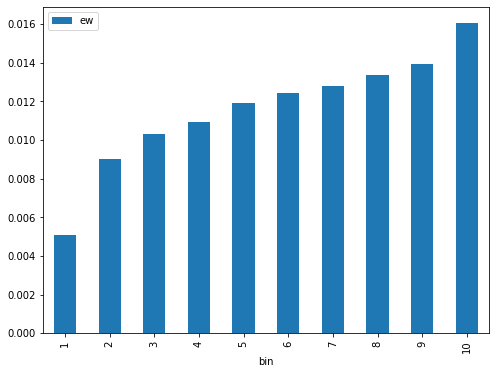

In [4]:
#@title Equal Weighted Strategy

import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

dta = portfolios.groupby('bin').agg(ew=('portfolio_ew', 'mean')).sort_values('bin')

dta

# barplot to check monotonicity
plt.rcParams["figure.figsize"] = (8,6)
dta.plot(kind='bar')



## Profit Loss Curve

In [6]:
#@title P&L curve: long the top decile, short the bottom decile
import mysql.connector
import pandas as pd
import numpy as np

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()


portfolios2 = pd.merge(
    portfolios.query('bin==10'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

portfolios2.head()

,date,bin_long,portfolio_ew_long,portfolio_vw_long,bin_short,portfolio_ew_short,portfolio_vw_short
0,1971-01-31,10,0.129188,0.068194,1,0.115097,0.039086
1,1971-02-28,10,0.039242,0.008931,1,0.054246,0.022252
2,1971-03-31,10,0.041070,0.034001,1,0.077382,0.066588
3,1971-04-30,10,0.038207,0.063372,1,0.027415,0.028245
4,1971-05-31,10,-0.059105,-0.039467,1,-0.041556,-0.031739


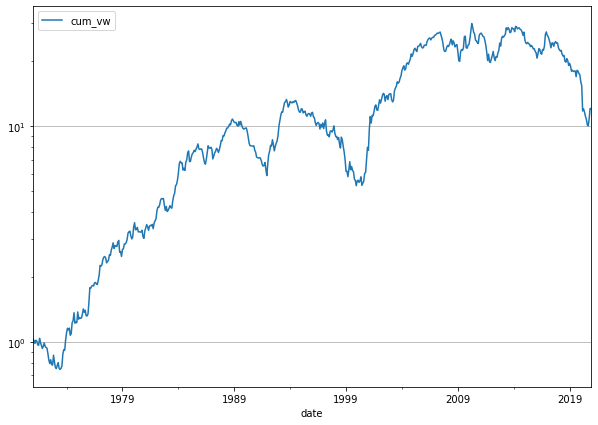

In [11]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

portfolios2 = pd.merge(
    portfolios.query('bin==10'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

plt.rcParams["figure.figsize"] = (10,7)

portfolios2 = portfolios2.sort_values('date') # sort it first

portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']

portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1 # calculates the cumulative return

(
    portfolios2
    .assign(date=pd.to_datetime(portfolios2['date']))
    .assign(cum_vw=portfolios2['cum_vw']+1)
    .plot(x='date', y=['cum_vw'], logy=True).grid(axis='y')
)


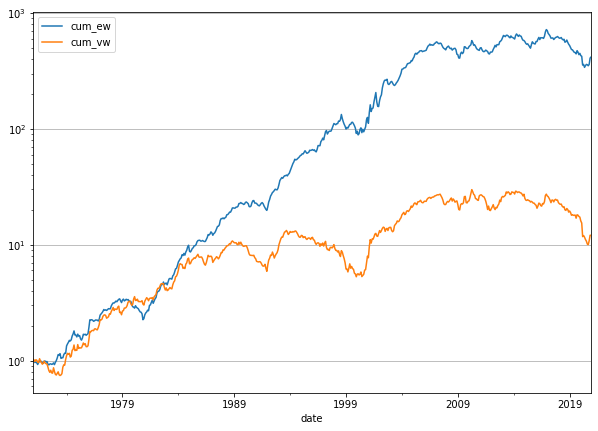

In [5]:
#@title Plot the Cummulative Returns for Both Strategies

import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

portfolios2 = pd.merge(
    portfolios.query('bin==10'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

plt.rcParams["figure.figsize"] = (10,7)

portfolios2 = portfolios2.sort_values('date') # sort it first

portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']

portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1 # calculates the cumulative return

portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long'] - portfolios2['portfolio_ew_short']

portfolios2['cum_ew'] = (portfolios2['strategy_ew'] + 1).cumprod() - 1 # calculates the cumulative return

(
    portfolios2
    .assign(date=pd.to_datetime(portfolios2['date']))
    .assign(cum_vw=portfolios2['cum_vw']+1)
    .assign(cum_ew=portfolios2['cum_ew']+1)
    .plot(x='date', y=['cum_ew', 'cum_vw'], logy=True).grid(axis='y')
)


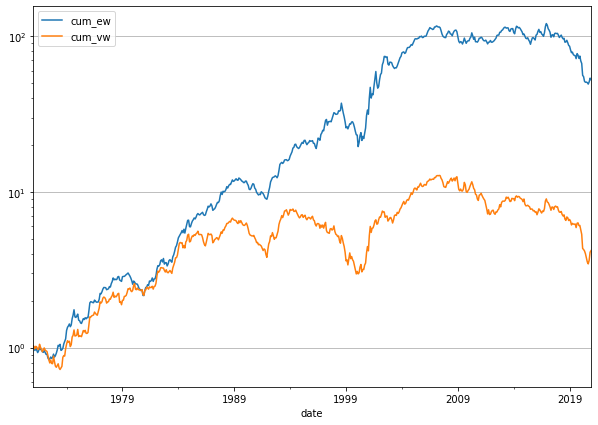

In [7]:
#@title Under Economic Restriction: prc_lag1>=5 and not in bottom 20%

import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>5 and hexcd in (1,2,3) and decile_mcap>2 and decile_vol>2')


def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

portfolios2 = pd.merge(
    portfolios.query('bin==10'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

plt.rcParams["figure.figsize"] = (10,7)

portfolios2 = portfolios2.sort_values('date') # sort it first

portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']

portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1 # calculates the cumulative return

portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long'] - portfolios2['portfolio_ew_short']

portfolios2['cum_ew'] = (portfolios2['strategy_ew'] + 1).cumprod() - 1 # calculates the cumulative return

(
    portfolios2
    .assign(date=pd.to_datetime(portfolios2['date']))
    .assign(cum_vw=portfolios2['cum_vw']+1)
    .assign(cum_ew=portfolios2['cum_ew']+1)
    .plot(x='date', y=['cum_ew', 'cum_vw'], logy=True).grid(axis='y')
)


## Fama-French Risk Benchmarking

In [6]:
#@title ff5: Value Weighted Strategy 

import mysql.connector
import pandas as pd
import numpy as np
import statsmodels.api as sm # statistical models including regression
import scipy as sp # scientific calculation toolkit
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt # MATLAB-like plotting library
import gc # garbage collector
import time # time related utility functions

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>1 and hexcd in (1,2,3)', 'crsp')

def apply_quantiles(x, include_in_quantiles=None, bins=10):
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)   
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    return pd.cut(x, quantiles, labels=False) + 1

required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()

portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

portfolios2 = pd.merge(
    portfolios.query('bin==10'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

portfolios2 = portfolios2.sort_values('date') # sort it first

portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']

portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1 # calculates the cumulative return

portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long'] - portfolios2['portfolio_ew_short']

portfolios2['cum_ew'] = (portfolios2['strategy_ew'] + 1).cumprod() - 1 # calculates the cumulative return



ff5 = queryMySQL("SELECT dt as date, mkt_rf, smb, hml, rmw, cma from ff.five_factor_monthly ff5 where mkt_rf is not null;")

(
    smf.ols('strategy_vw ~ 1 + mkt_rf + smb + hml + rmw + cma', 
            data=pd.merge(ff5, portfolios2, on='date'))
    .fit().summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            strategy_vw   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     243.1
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          6.83e-141
Time:                        09:18:27   Log-Likelihood:                 1303.4
No. Observations:                 598   AIC:                            -2595.
Df Residuals:                     592   BIC:                            -2568.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.001      0.629      0.530      -0.002       0.003
mkt_rf         0.0726      0.028      2.554      0.011       0.017       0.128
smb            0.4335      0.041     10.523      0.000       0.353       0.514
hml            1.0223      0.052     19.498      0.000       0.919       1.125
rmw           -0.1760      0.055     -3.191      0.001      -0.284      -0.068
cma            0.5019      0.083      6.043      0.000       0.339       0.665
==============================================================================
Omnibus:                       37.403   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.905
Skew:                          -0.277   Prob(JB):                     2.02e-22
Kurtosis:                       4.924   Cond. No.                         82.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#@title ff5: Equal Weighted Strategy

import mysql.connector
import pandas as pd
import numpy as np

def connect(db='crsp'):
  conn = mysql.connector.connect(host='147.8.122.231',user='fina_4359_fengjy18',password='9d93d',database=db)
  return conn

def queryMySQL(x, db='crsp'):
  conn = connect(db=db)
  response = pd.read_sql(x,conn)
  conn.close()
  return response

required_data = queryMySQL('SELECT * FROM temp.hw3_mysterymeat_2021 WHERE prc_lag1>5 and hexcd in (1,2,3) and decile_mcap>2 and decile_vol>2')


def apply_quantiles(x, include_in_quantiles=None, bins=10):
    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1


required_data['bin'] = (
    required_data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['mystery_meat'],bins=10))
).reset_index(level=[0], drop=True).sort_index()


portfolios = (
    required_data
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

portfolios2 = pd.merge(
    portfolios.query('bin==10'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

plt.rcParams["figure.figsize"] = (10,7)

portfolios2 = portfolios2.sort_values('date') # sort it first

portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']

portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1 # calculates the cumulative return

portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long'] - portfolios2['portfolio_ew_short']

portfolios2['cum_ew'] = (portfolios2['strategy_ew'] + 1).cumprod() - 1 # calculates the cumulative return

(
    portfolios2
    .assign(date=pd.to_datetime(portfolios2['date']))
    .assign(cum_vw=portfolios2['cum_vw']+1)
    .assign(cum_ew=portfolios2['cum_ew']+1)
    .plot(x='date', y=['cum_ew', 'cum_vw'], logy=True).grid(axis='y')
)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            strategy_ew   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     86.49
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           1.30e-48
Time:                        22:09:52   Log-Likelihood:                 1023.2
No. Observations:                 822   AIC:                            -2038.
Df Residuals:                     818   BIC:                            -2019.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0107      0.002      4.369      0.000       0.006       0.016
hml           -0.7586      0.074    -10.273      0.000      -0.904      -0.614
mkt_rf        -0.2815      0.050     -5.662      0.000      -0.379      -0.184
smb           -0.4596      0.081     -5.643      0.000      -0.619      -0.300
==============================================================================
Omnibus:                      562.453   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14333.113
Skew:                          -2.714   Prob(JB):                         0.00
Kurtosis:                      22.723   Cond. No.                         34.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
## Functionalize --> 

In [ ]:
# Put this in a function
def performAnalysis(msf3):
    # Second, let's assign every stock based on their lag return
    msf3['bin'] = (
        msf3
        .groupby('date')
        .apply(lambda group: apply_quantiles(group['momentum'], bins=10, include_in_quantiles=(group['hexcd']==1)))
    ).reset_index(level=[0], drop=True).sort_index()

    # Alternatively, we can just do this.
    msf3['bin2'] = (
        msf3
        .groupby('date')
        .apply(lambda group: np.ceil(group['momentum'].rank() / len(group['momentum']) * 10))
    ).reset_index(level=[0], drop=True).sort_index()
    
    portfolios = (
        msf3
        .groupby(['date', 'bin'])
        .apply(
            lambda g: pd.Series({
                'portfolio_ew': g['ret'].mean(),
                'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
            })
        )
    ).reset_index()

    portfolios2 = pd.merge(
        portfolios.query('bin==10'),
        portfolios.query('bin==1'),
        suffixes=['_long', '_short'],
        on='date'
    )

    portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']

    portfolios2 = portfolios2.sort_values('date') # sort it first

    portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1 # calculates the cumulative return

    portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long'] - portfolios2['portfolio_ew_short']

    portfolios2['cum_ew'] = (portfolios2['strategy_ew'] + 1).cumprod() - 1 # calculates the cumulative return

    (
        portfolios2
        .assign(date=pd.to_datetime(portfolios2['date']))
        .assign(cum_vw=portfolios2['cum_vw']+1)
        .assign(cum_ew=portfolios2['cum_ew']+1)
        .plot(x='date', y=['cum_ew', 'cum_vw'], logy=True).grid(axis='y')
    )

    portfolios3 = pd.merge(ff4, portfolios2, on='date')
    
    l1 = smf.ols('strategy_vw ~ 1 + hml + mkt_rf + smb', data=portfolios3 ).fit()
    l2 = smf.ols('strategy_ew ~ 1 + hml + mkt_rf + smb', data=portfolios3 ).fit()
    
    print(sm.iolib.summary2.summary_col([l1, l2], stars=True))

